In [3]:
import scipy.io
import numpy as np
import scipy.signal as signal
import matplotlib.pyplot as plt
from scipy.fft import rfft, rfftfreq


In [4]:
playback_44100 = scipy.io.loadmat('./data/playback_44100.mat')['w441'].reshape(-1)

playback_44100 = playback_44100[44100:44100*2]

print("len playback_44100 :", len(playback_44100))

fs_out = 48_000

fs_in = 44_100

# playback_48000 = signal.resample(playback_44100, int(len(playback_44100) * freq_target / 44_100))

len playback_44100 : 44100


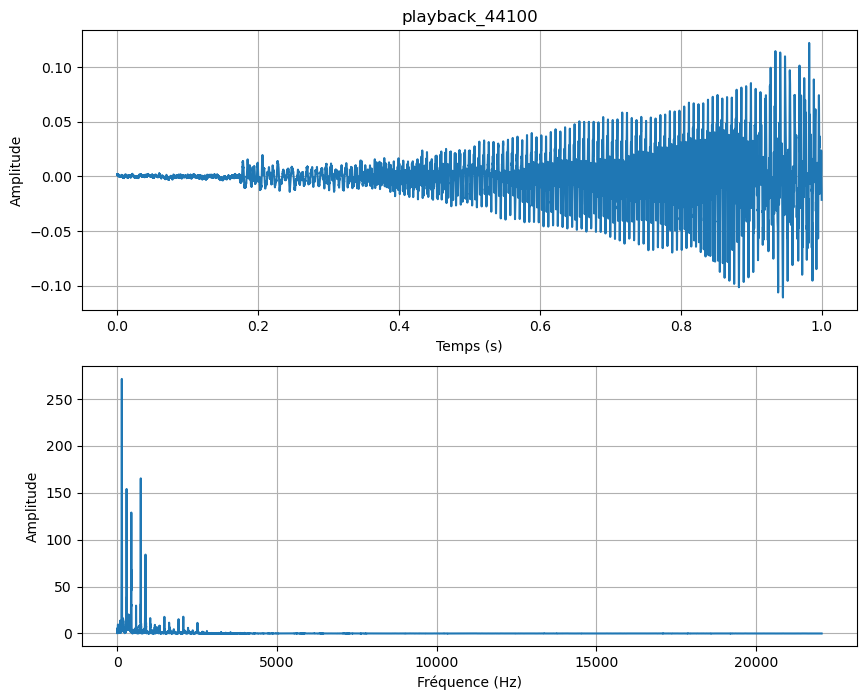

In [5]:
def plot_signal(signal, freq, title):
    
    t = np.arange(0, len(signal)/freq, 1/freq)
    
    signal_fft = rfft(signal)
    signal_freq = rfftfreq(len(signal), 1/freq)
    
    plt.figure(figsize=(10, 8))
    plt.subplot(2, 1, 1)
    plt.plot(t, signal)
    plt.title(title)
    plt.grid()
    plt.xlabel("Temps (s)")
    plt.ylabel("Amplitude")
    
    
    plt.subplot(2, 1, 2)
    plt.plot(signal_freq, np.abs(signal_fft))
    # plt.title(title)
    plt.grid()
    plt.xlabel("Fréquence (Hz)")
    plt.ylabel("Amplitude")

plot_signal(playback_44100, fs_in,  "playback_44100")  



In [6]:


print("Le plus grand commun diviseur de 44100 et 48000 est :", np.gcd(fs_in, fs_out))

def UpSample(signal, factor):
    upsampled = np.zeros(len(signal) * factor)
    upsampled[::factor] = signal
    return upsampled

def DownSample(signal, factor):
    return signal[::factor]


Le plus grand commun diviseur de 44100 et 48000 est : 300


Text(0, 0.5, 'Amplitude')

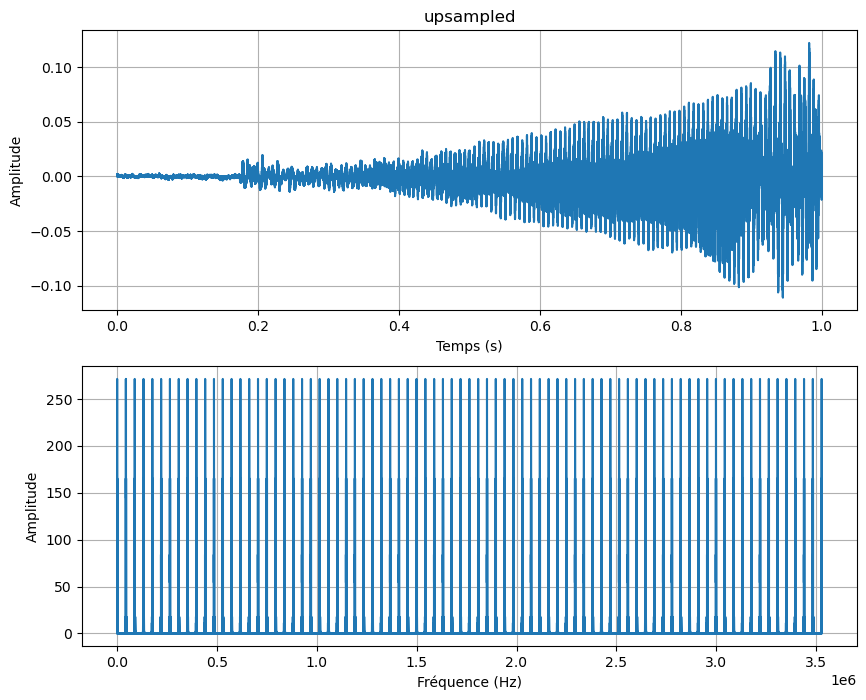

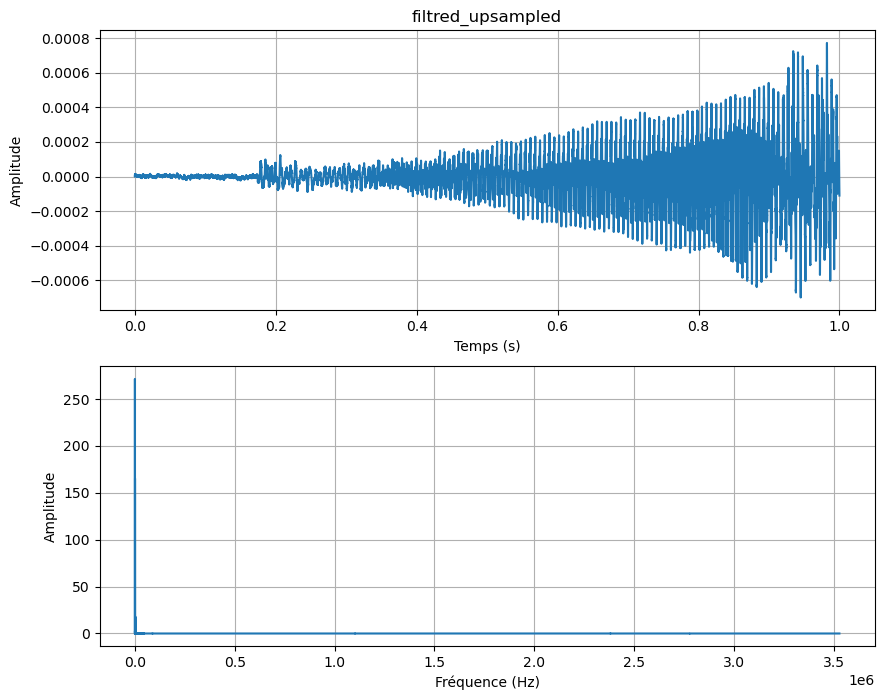

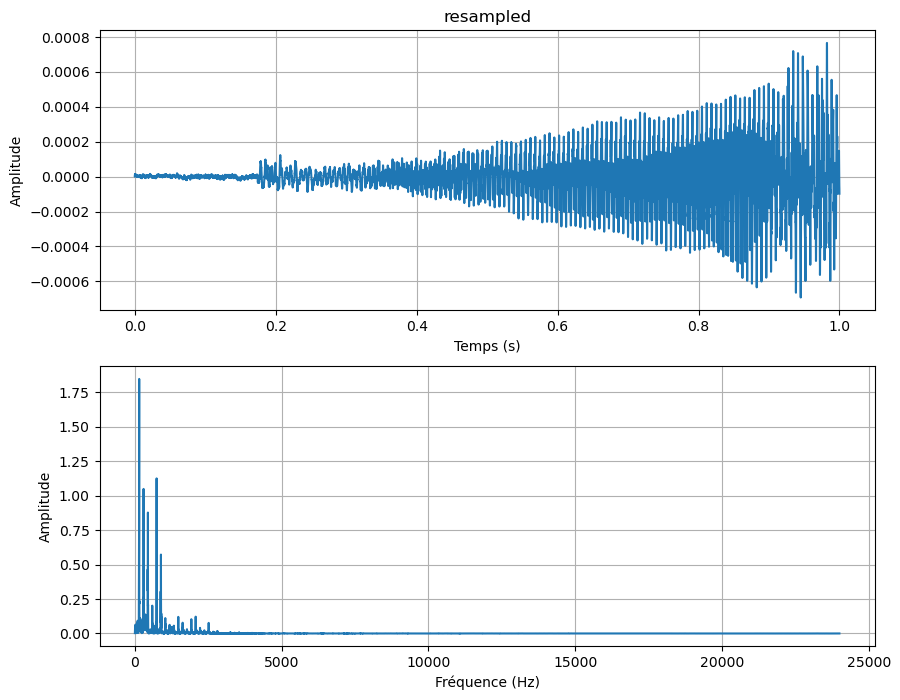

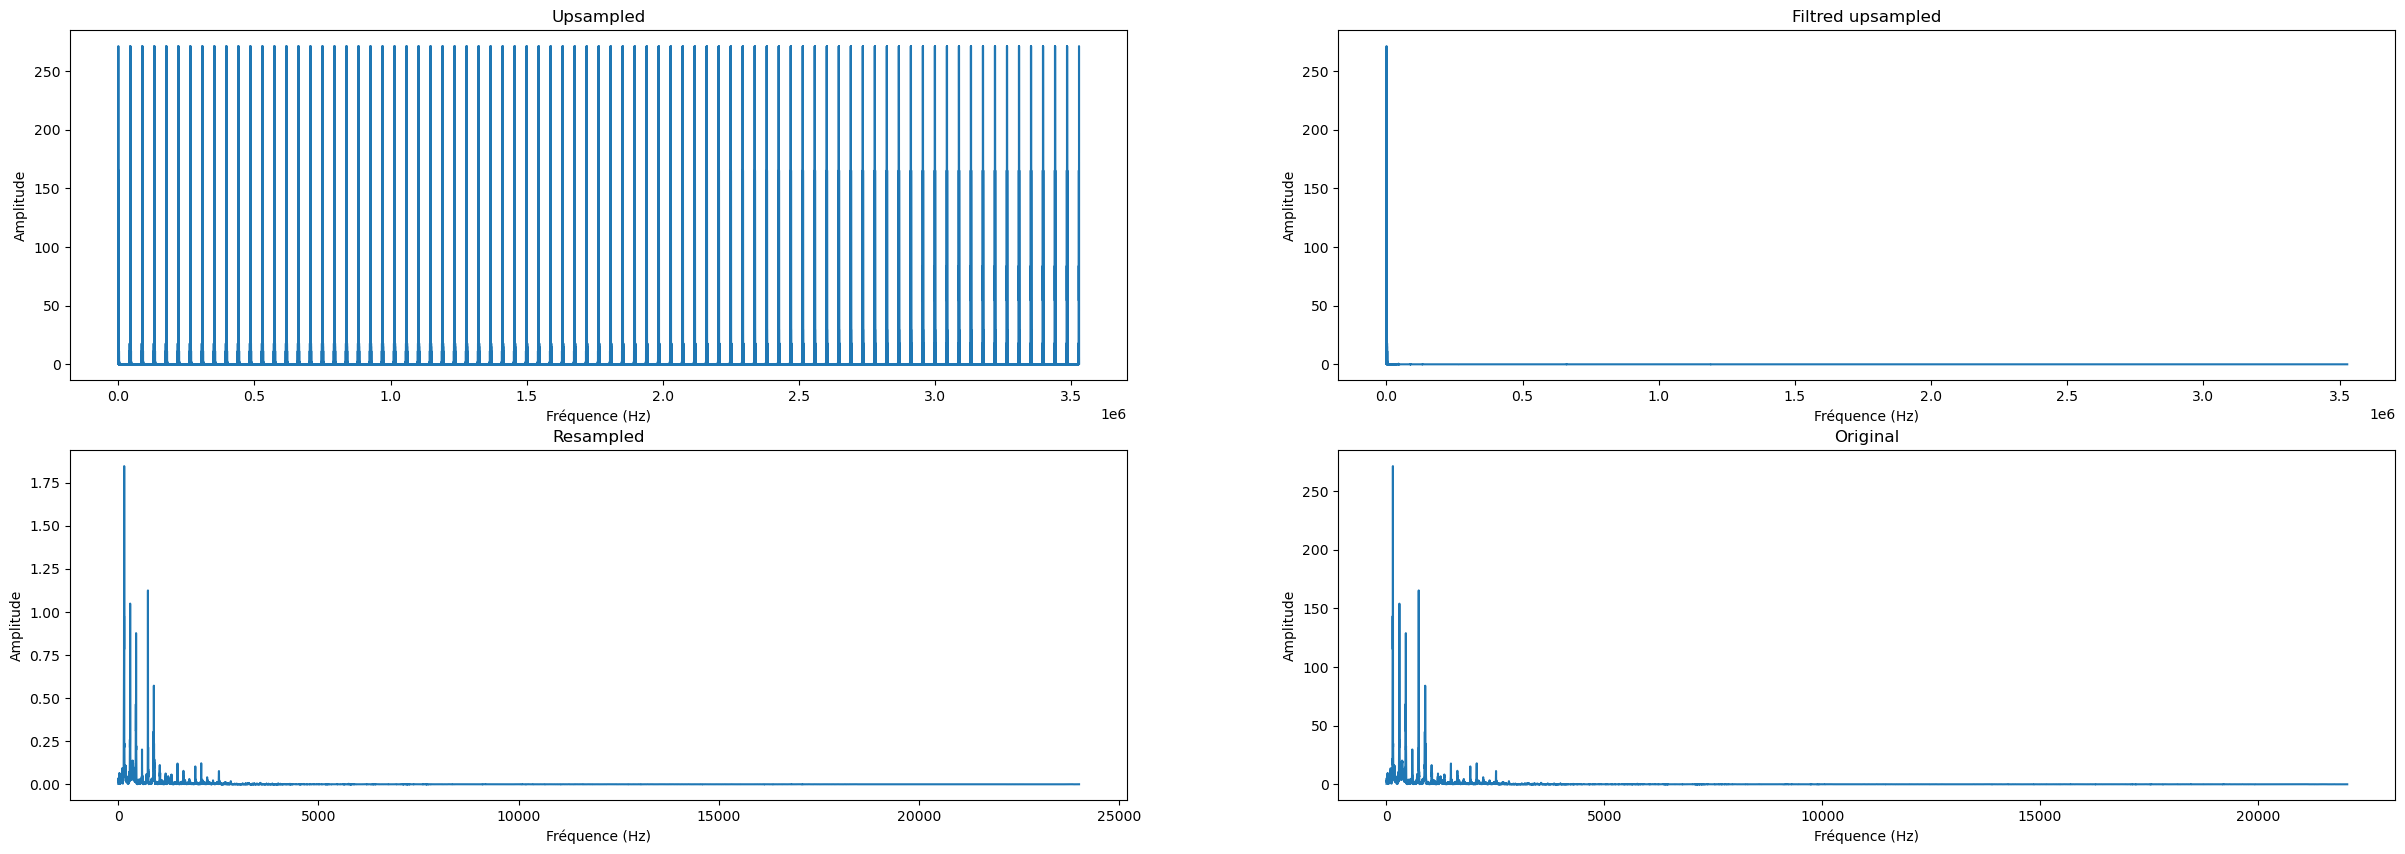

In [7]:
factor = np.gcd(fs_in, fs_out)

up_factor = fs_out // factor
down_factor = fs_in // factor

upsampled = UpSample(playback_44100, up_factor)


plot_signal(upsampled, fs_in*up_factor, "upsampled")



cutoff = 1/down_factor
taps = signal.firwin(numtaps=801, cutoff=cutoff)

filtred_upsampled = signal.lfilter(taps, 1.0, upsampled)


plot_signal(filtred_upsampled, fs_in*up_factor, "filtred_upsampled")

resampled = DownSample(filtred_upsampled, down_factor)

plot_signal(resampled, fs_out, "resampled")

plt.figure(figsize=(15*2, 5*2))

plt.subplot(2, 2, 1)
plt.plot(rfftfreq(len(upsampled), 1/fs_in/up_factor), np.abs(rfft(upsampled)))
plt.title("Upsampled")
plt.xlabel("Fréquence (Hz)")
plt.ylabel("Amplitude")

plt.subplot(2, 2, 2)
plt.plot(rfftfreq(len(filtred_upsampled), 1/fs_in/up_factor), np.abs(rfft(filtred_upsampled)))
plt.title("Filtred upsampled")
plt.xlabel("Fréquence (Hz)")
plt.ylabel("Amplitude")

plt.subplot(2, 2, 3)
plt.plot(rfftfreq(len(resampled), 1/fs_out), np.abs(rfft(resampled)))
plt.title("Resampled")
plt.xlabel("Fréquence (Hz)")
plt.ylabel("Amplitude")

plt.subplot(2, 2, 4)
plt.plot(rfftfreq(len(playback_44100), 1/fs_in), np.abs(rfft(playback_44100)))
plt.title("Original")
plt.xlabel("Fréquence (Hz)")
plt.ylabel("Amplitude")





In [8]:
def NaiveResample(signal, fs_in, fs_out):
    
    gcd = np.gcd(fs_in, fs_out)
    
    upsampled = UpSample(signal, fs_out // gcd)
    
    cutoff = 1/(fs_in // gcd)
    
    taps = signal.firwin(numtaps=101, cutoff=cutoff)
    
    filtred_upsampled = signal.lfilter(taps, 1.0, upsampled)
    
    resampled = DownSample(filtred_upsampled, fs_in // gcd)
    
    return resampled




## Filtre en cascade

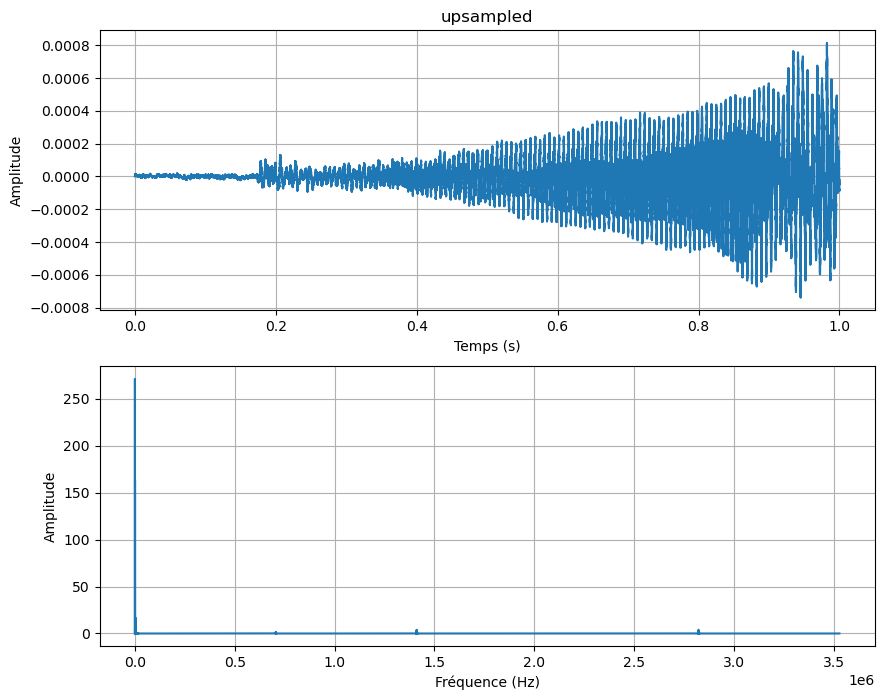

In [18]:
from sympy import factorint


gcd = np.gcd(fs_in, fs_out)

up_factor = fs_out // gcd
down_factor = fs_in // gcd


    # Décomposition des facteurs en nombres premiers
up_factors = factorint(up_factor, multiple=True)
down_factors = factorint(down_factor, multiple=True)

x = playback_44100

for factor in up_factors:
    
    x = UpSample(x, factor)
    cutoff = 1 / (2 * factor)
    taps = signal.firwin(numtaps=11, cutoff=cutoff, fs=fs_in * up_factor)
    x = signal.lfilter(taps, 1.0, x)
    



plot_signal(x, fs_in*up_factor, "upsampled")



# cutoff = 1/down_factor
# taps = signal.firwin(numtaps=801, cutoff=cutoff)

# filtred_upsampled = signal.lfilter(taps, 1.0, upsampled)



# plot_signal(filtred_upsampled, fs_in*up_factor, "filtred_upsampled")

# resampled = DownSample(filtred_upsampled, down_factor)

# plot_signal(resampled, fs_out, "resampled")

# plt.figure(figsize=(15*2, 5*2))

# plt.subplot(2, 2, 1)
# plt.plot(rfftfreq(len(upsampled), 1/fs_in/up_factor), np.abs(rfft(upsampled)))
# plt.title("Upsampled")
# plt.xlabel("Fréquence (Hz)")
# plt.ylabel("Amplitude")

# plt.subplot(2, 2, 2)
# plt.plot(rfftfreq(len(filtred_upsampled), 1/fs_in/up_factor), np.abs(rfft(filtred_upsampled)))
# plt.title("Filtred upsampled")
# plt.xlabel("Fréquence (Hz)")
# plt.ylabel("Amplitude")

# plt.subplot(2, 2, 3)
# plt.plot(rfftfreq(len(resampled), 1/fs_out), np.abs(rfft(resampled)))
# plt.title("Resampled")
# plt.xlabel("Fréquence (Hz)")
# plt.ylabel("Amplitude")

# plt.subplot(2, 2, 4)
# plt.plot(rfftfreq(len(playback_44100), 1/fs_in), np.abs(rfft(playback_44100)))
# plt.title("Original")
# plt.xlabel("Fréquence (Hz)")
# plt.ylabel("Amplitude")
